## design leader sequence

In [1]:
import infrared as ir
import infrared.rna as rna
import RNA
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

In [3]:
PK1_deleted = 'CCUCAGGCCAGAAAUGCCACCGGAUAAAGGUAGACGGUGCCGCCUGCAACCUUU'
PK2_deleted = 'AGUCAGGCCAGAAAUGCCACCGGAUCGAAAGAGACGGUGCUGCCUGCAAAAAAA'
PK2_2_5 =     'AGUCAGGCCAGAAAUGCCACCGGAUAUGUGUAGACGGUGCUGCCUGCAAAAUCU'
PK2_3_98 =    'AGUCAGGCCAGAAAUGCCACCGGAUAUGCUUAGACGGUGCUGCCUGCAACGUAU'
PK2_0_99 =    'AGUCAGGCCAGAAAUGCCACCGGAUAGAAGUAGACGGUGCUGCCUGCAAGUAGU'

In [4]:
all_seqs = [PK1_deleted, PK2_deleted, PK2_2_5, PK2_3_98, PK2_0_99]

In [5]:
extended_iupac_nucleotides = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'U': 'U',
    'R': 'AG',
    'N': 'ACGU',
    'X': 'ACGU-',
    '-': '-',
    '.': '-'
}


def iupacvalues(symbol):
    return [ rna.nucleotide_to_value(x) for x in extended_iupac_nucleotides[symbol] ]

def sample_to_seq(sample):
    return rna.values_to_seq(sample.values())

def calculate_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq)

In [48]:
## GCUAA stays unpaired
target =         ".........((((((.....))))))...."
iupac_sequence = 'GCUAANNNXNNNNNXNNNXXXNNNNNNNXX'
n = len(target)
model = ir.Model()
model.add_variables(n, 5)

for i, x in enumerate(iupac_sequence):
    model.add_constraints(ir.ValueIn(i, iupacvalues(x)))

model.add_constraints(rna.BPComp(i,j) for (i,j) in rna.parse(target))
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')

sampler = ir.Sampler(model)
# samples = [sample_to_seq(sampler.sample()) for _ in range(10000)]
sampler.set_target( 0.5 * n, 0.1 * n, 'gc' )
samples = [sample_to_seq(sampler.targeted_sample()) for _ in tqdm(range(500000))]

100%|████████████████████████████████| 500000/500000 [00:18<00:00, 26749.14it/s]


In [49]:
def target_frequency(sequence, ss):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(ss)

def acceptable_seq(ss):
    if ss.startswith('........') and ss.endswith('..') :
        return True
    return False

In [50]:
ok_leader= []
for seq in tqdm(samples):
    seq_ = seq.replace('-','')
    fc  = RNA.fold_compound(seq_)
    (ss, mfe) = fc.mfe()
    if acceptable_seq(ss):
        ok_leader.append(seq)

100%|█████████████████████████████████| 500000/500000 [01:04<00:00, 7808.87it/s]


In [51]:
len(ok_leader)

185314

In [52]:
fc = RNA.fold_compound(PK1_deleted)
(ss, mfe) = fc.mfe()
print(PK1_deleted)
print(ss)

fc = RNA.fold_compound(PK2_deleted)
(ss, mfe) = fc.mfe()
print(PK2_deleted)
print(ss)

fc = RNA.fold_compound(PK2_2_5)
(ss, mfe) = fc.mfe()
print(PK2_2_5)
print(ss)

fc = RNA.fold_compound(PK2_3_98)
(ss, mfe) = fc.mfe()
print(PK2_3_98)
print(ss)

fc = RNA.fold_compound(PK2_0_99)
(ss, mfe) = fc.mfe()
print(PK2_0_99)
print(ss)


CCUCAGGCCAGAAAUGCCACCGGAUAAAGGUAGACGGUGCCGCCUGCAACCUUU
...(((((.......(.(((((..((....))..))))).))))))........
AGUCAGGCCAGAAAUGCCACCGGAUCGAAAGAGACGGUGCUGCCUGCAAAAAAA
.(.(((((.((......(((((..((....))..))))))))))))).......
AGUCAGGCCAGAAAUGCCACCGGAUAUGUGUAGACGGUGCUGCCUGCAAAAUCU
.(.(((((.((......(((((..((....))..))))))))))))).......
AGUCAGGCCAGAAAUGCCACCGGAUAUGCUUAGACGGUGCUGCCUGCAACGUAU
.(.(((((.((......(((((..((....))..))))))))))))).......
AGUCAGGCCAGAAAUGCCACCGGAUAGAAGUAGACGGUGCUGCCUGCAAGUAGU
.(.(((((.((......(((((..((....))..))))))))))))).......


In [53]:
def print_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss, sample_size=1000):
    ss_leader = remove_positioned_gaps(leader_seq, target)
    target_ss = ss_leader + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq
    
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    suboptimal_ss = []
    for s in fc.subopt(sample_size):
        if s.structure not in suboptimal_ss:
            print(seq)
            print(f"{s.structure}\t{s.energy:6.2f}")
            print(target_ss)
            print(f'{"-" * len(ss_leader) + "+" * len(xrRNA_seq)}\n')
            suboptimal_ss.append(s.structure)
    return True

In [54]:
def test_interaction(leader_seq, xrRNA_seq, threshold = 0.01):
    leader_seq = leader_seq.replace('-','')

    seq = leader_seq + xrRNA_seq
    fold_compound = RNA.fold_compound(seq)
    fold_compound.pf()
    base_pair_probs = np.array(fold_compound.bpp())
    for i in range(len(leader_seq)):
        for j in range(len(leader_seq), len(seq)):
            if base_pair_probs[i][j] > threshold:  # Adjust threshold as needed
                return False
    return True

In [66]:
seq = best_seq + xrRNA_seq
fold_compound = RNA.fold_compound(seq)
fold_compound.pf()
base_pair_probs = np.array(fold_compound.bpp())
for i in range(len(best_seq)):
    for j in range(len(best_seq), len(seq)):
        print(i,j)

0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
1 30
1 31
1 32
1 33
1 34
1 35
1 36
1 37
1 38
1 39
1 40
1 41
1 42
1 43
1 44
1 45
1 46
1 47
1 48
1 49
1 50
1 51
1 52
1 53
1 54
1 55
1 56
1 57
1 58
1 59
1 60
1 61
1 62
1 63
1 64
1 65
1 66
1 67
1 68
1 69
1 70
1 71
1 72
1 73
1 74
1 75
1 76
1 77
1 78
1 79
1 80
1 81
1 82
1 83
2 30
2 31
2 32
2 33
2 34
2 35
2 36
2 37
2 38
2 39
2 40
2 41
2 42
2 43
2 44
2 45
2 46
2 47
2 48
2 49
2 50
2 51
2 52
2 53
2 54
2 55
2 56
2 57
2 58
2 59
2 60
2 61
2 62
2 63
2 64
2 65
2 66
2 67
2 68
2 69
2 70
2 71
2 72
2 73
2 74
2 75
2 76
2 77
2 78
2 79
2 80
2 81
2 82
2 83
3 30
3 31
3 32
3 33
3 34
3 35
3 36
3 37
3 38
3 39
3 40
3 41
3 42
3 43
3 44
3 45
3 46
3 47
3 48
3 49
3 50
3 51
3 52
3 53
3 54
3 55
3 56
3 57
3 58
3 59
3 60
3 61
3 62
3 63
3 64
3 65
3 66
3 67


In [65]:
print(base_pair_probs[0][0])

0.0


In [55]:
good_candidates_both = []
good_candidates = []

for seq in tqdm(ok_leader):
    if test_interaction(seq, PK1_deleted, 0.01):
        good_candidates.append(seq)


100%|██████████████████████████████████| 185314/185314 [14:54<00:00, 207.13it/s]


In [56]:
len(good_candidates)

21

In [ ]:
best_seq = None
best_freq = 0
fc = RNA.fold_compound(PK1_deleted)
(ss, mfe) = fc.mfe()
for seq in tqdm(ok_leader):
    cur_ss = remove_positioned_gaps(seq, target)
    cur_ss += ss
    cur_seq = seq + PK1_deleted
    cur_freq = target_frequency(cur_seq, cur_ss)
    
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(cur_seq, cur_ss), 3))

  0%|                                        | 32/185370 [00:00<18:27, 167.31it/s]

0.0
0.0
0.0
0.0
0.0
0.001
0.001


  0%|                                       | 124/185370 [00:00<14:14, 216.72it/s]

0.002


  0%|                                       | 587/185370 [00:02<13:46, 223.51it/s]

0.002


  2%|▌                                     | 2929/185370 [00:13<13:32, 224.60it/s]

0.002


  8%|██▊                                  | 14379/185370 [01:06<13:08, 216.99it/s]

0.002


 28%|██████████▎                          | 51972/185370 [03:53<09:51, 225.37it/s]

0.002


 32%|███████████▋                         | 58529/185370 [04:22<09:17, 227.72it/s]

0.002


 67%|████████████████████████▎           | 125073/185370 [09:19<04:28, 224.85it/s]

In [57]:
best_seq = None
best_freq = 0
fc = RNA.fold_compound(PK1_deleted)
(ss, mfe) = fc.mfe()
for seq in tqdm(good_candidates):
    cur_ss = remove_positioned_gaps(seq, target)
    cur_ss += ss
    cur_seq = seq + PK1_deleted
    cur_freq = target_frequency(cur_seq, cur_ss)
    
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(cur_seq, cur_ss), 3))

100%|██████████████████████████████████████████| 21/21 [00:00<00:00, 179.17it/s]

0.0
0.002
0.002
0.085
0.092


In [58]:
best_seq

'GCUAAUCGCCCAGCCCCG-UGGUUGGAUAA'

In [11]:
seq_stored = 'GCUAAACACGCUCACGGUAAGUGAGCAAA-'

seq_new = 'GCUAAACACGCUCACGGUAAGUGAGCAAA-'
seq_mc = 'GCUAAAAAAGACACCUACCGGUGUCAA'

In [67]:
best_seq = seq_mc


GCUAAAAAAGACACCUACCGGUGUCAACCUCAGGCCAGAAAUGCCACCGGAUAAAGGUAGACGGUGCCGCCUGCAACCUUU
.........((((((....)))))).....(((((.......(.(((((..((....))..))))).))))))........ (-22.90)
.........((((((....)))))).....(((((.......(.(((((..((....))..))))),,)))))........ [-23.88]
.........((((((....)))))).....(((((.........(((((..((....))..)))))..)))))........ {-22.40 d=4.45}
.........((((((....)))))).....(((((.......(.(((((..((....))..))))).))))))........ {-22.90 MEA=73.78}
 frequency of mfe structure in ensemble 0.203443; ensemble diversity 7.45  
GCUAAAAAAGACACCUACCGGUGUCAAAGUCAGGCCAGAAAUGCCACCGGAUCGAAAGAGACGGUGCUGCCUGCAAAAAAA
.........((((((....))))))...(.(((((.((......(((((..((....))..)))))))))))))....... (-27.70)
.........((((((....))))))...(.(((({,((......(((((..((....))..)))))))))))))....... [-28.49]
.........((((((....))))))...(.(((((.((......(((((..((....))..)))))))))))))....... {-27.70 d=1.85}
.........((((((....))))))...(.(((((.((......(((((..((....))..)))))))))))))....... {-27.70 MEA=77.99

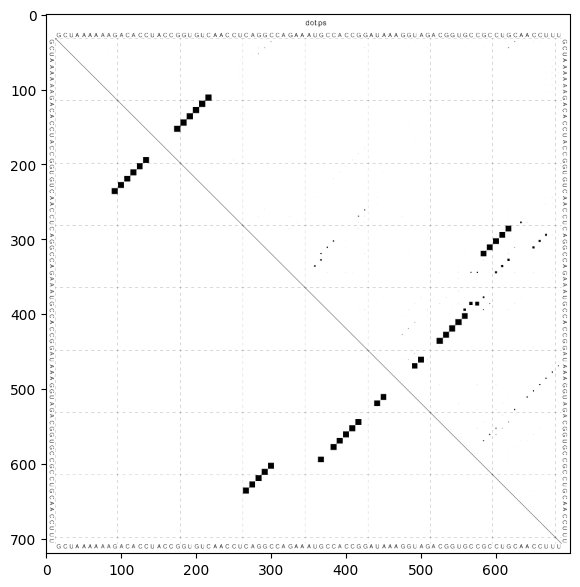

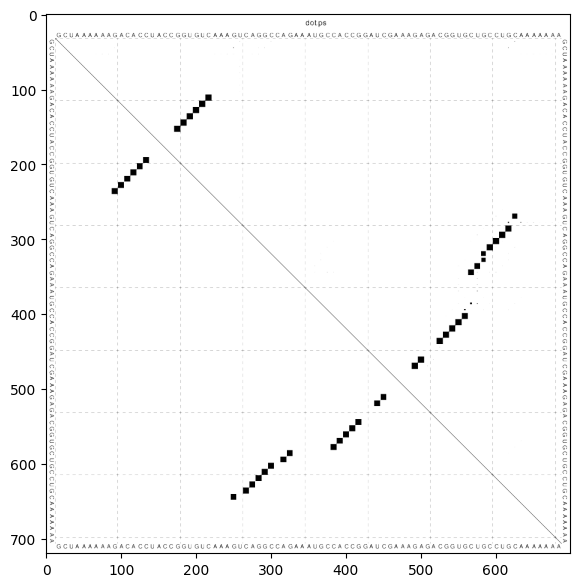

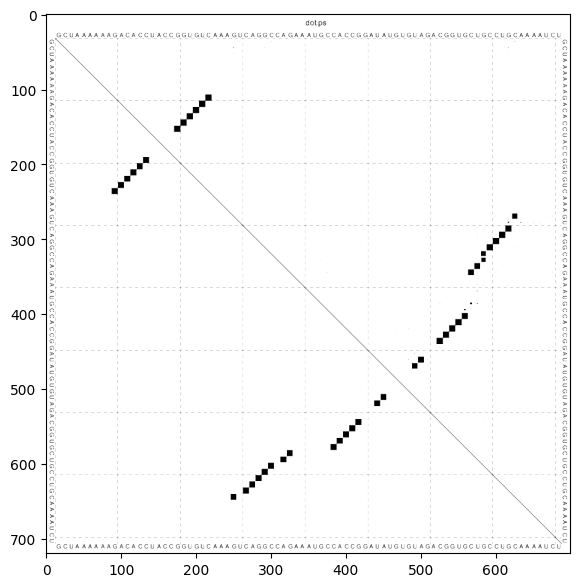

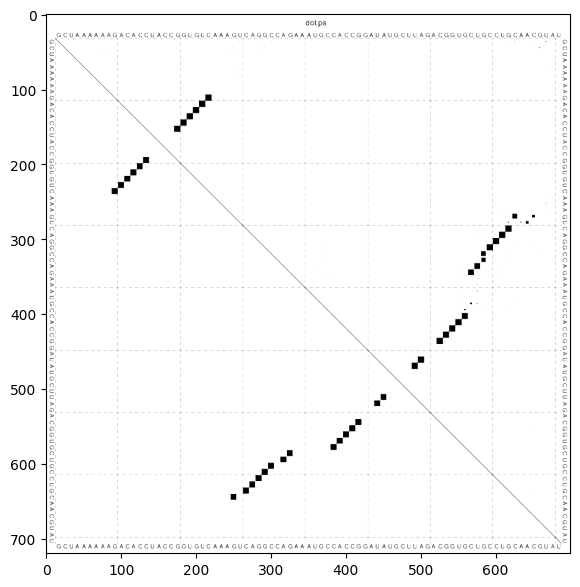

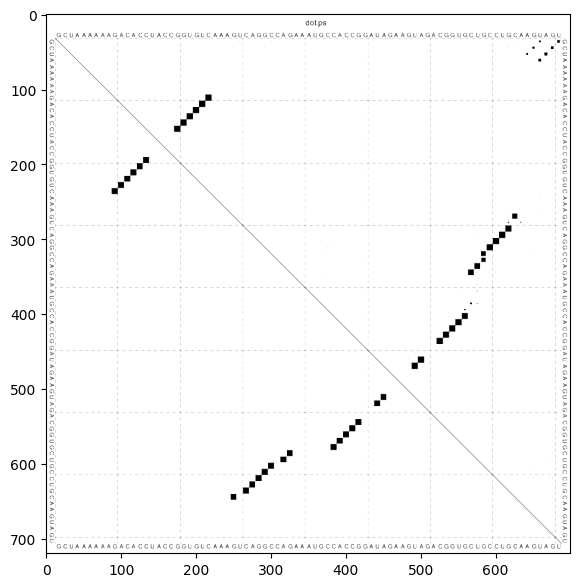

In [68]:
for xrRNA_seq in all_seqs:
    seq = best_seq.replace('-', '') + xrRNA_seq
    !echo $seq > test.seq
    !RNAfold -p --MEA < test.seq
    !convert dot.ps dot.png
    
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    image = mpimg.imread("dot.png")
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(image)